In [211]:
import os
from dotenv import load_dotenv
load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

In [212]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [213]:
# load the data
df = pd.read_csv('./locations.csv')

# Locations

In [214]:
df.head()

,place_id,name,avg_rating,lat,lng,user_ratings_total,reviews
0,ChIJ1e5UJJF0j1QR6VpPNf8TYiQ,Royal BC Museum,4.6,48.419811,-123.367450,8661,Great museum has very nice and extensive exhib...
1,ChIJmXc0Z6J0j1QR4CJUS73dyZk,Fisherman's Wharf Park,4.5,48.421950,-123.383014,7523,A popular tourist attraction on the Victoria w...
2,ChIJueKTCmtzj1QRxJZTfhNWlsY,Esquimalt Gorge Park & Pavilion,4.7,48.446345,-123.404949,1078,This park is so lovely! City staff do a great ...
3,ChIJ5ZScPpF0j1QRBLCY8tTvWsM,Thunderbird Park,4.3,48.419794,-123.366680,203,Like the totems and of course worth visiting t...
4,ChIJS9YYcJB0j1QRPWHIFtwTr18,Victoria Bug Zoo,4.5,48.423300,-123.366668,1822,My daughter and I had a fantastic time at the ...


In [215]:
df.shape

(357, 7)

## Cleaning

In [216]:
# look at missing values as a total and a percentage
df.isnull().sum()

place_id               0
name                   0
avg_rating             0
lat                    0
lng                    0
user_ratings_total     0
reviews               26
dtype: int64

In [217]:
# drop the rows with missing values in reviews
df.dropna(subset=['reviews'], inplace=True)

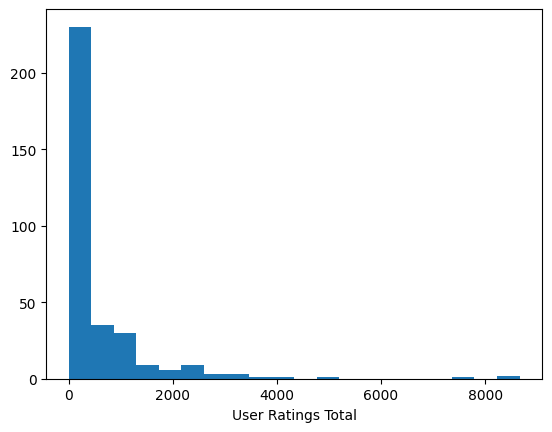

In [218]:
# look at the distribution of user_ratings_total
plt.hist(df['user_ratings_total'], bins=20)
# add an x-axis label
plt.xlabel('User Ratings Total')
plt.show()

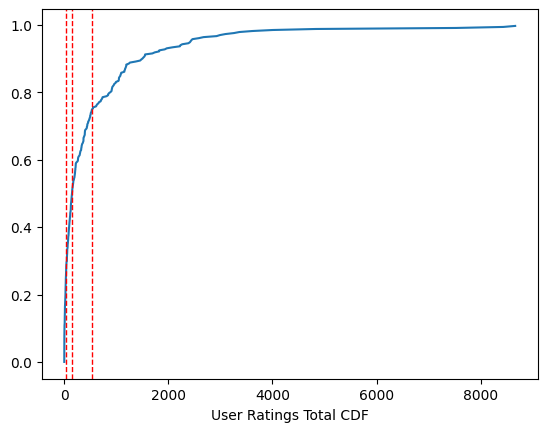

In [219]:
# plot the CDF of user_ratings_total as a line
plt.plot(np.sort(df['user_ratings_total']), np.linspace(0, 1, len(df), endpoint=False))
# plot the quartiles as red dashed lines
plt.axvline(df['user_ratings_total'].quantile(0.25), color='red', linestyle='dashed', linewidth=1)
plt.axvline(df['user_ratings_total'].quantile(0.5), color='red', linestyle='dashed', linewidth=1)
plt.axvline(df['user_ratings_total'].quantile(0.75), color='red', linestyle='dashed', linewidth=1)

# add an x-axis label
plt.xlabel('User Ratings Total CDF')

plt.show()

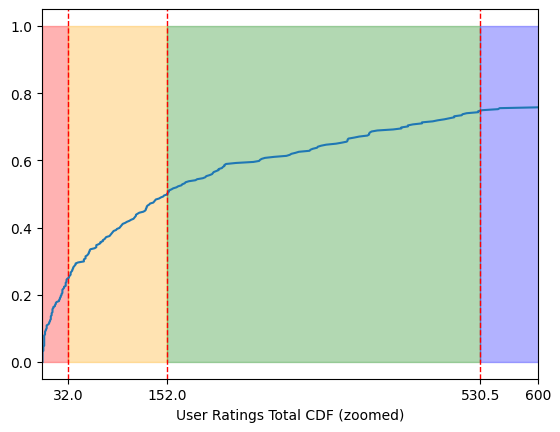

In [220]:
# plot the CDF of user_ratings_total as a line zoomed into 0-1000
plt.plot(np.sort(df['user_ratings_total']), np.linspace(0, 1, len(df), endpoint=False))
plt.xlim(0, 600)
# plot the quartiles as red dashed lines with a label for each quartile
plt.axvline(df['user_ratings_total'].quantile(0.25), color='red', linestyle='dashed', linewidth=1, label='Q1')
plt.axvline(df['user_ratings_total'].quantile(0.5), color='red', linestyle='dashed', linewidth=1, label='Q2')
plt.axvline(df['user_ratings_total'].quantile(0.75), color='red', linestyle='dashed', linewidth=1, label='Q3')

# adding fill

# fill between 0 and Q1
plt.fill_between([0, df['user_ratings_total'].quantile(0.25)], 0, 1, alpha=0.3, color='red')

# fill between Q1 and Q2
plt.fill_between([df['user_ratings_total'].quantile(0.25), df['user_ratings_total'].quantile(0.5)], 0, 1, alpha=0.3, color='orange')

# fill between Q2 and Q3
plt.fill_between([df['user_ratings_total'].quantile(0.5), df['user_ratings_total'].quantile(0.75)], 0, 1, alpha=0.3, color='green')

# fill between Q3 and max
plt.fill_between([df['user_ratings_total'].quantile(0.75), df['user_ratings_total'].max()], 0, 1, alpha=0.3, color='blue')

# add the numerical values of the quartiles on the x-axis
Q1 = df['user_ratings_total'].quantile(0.25)
Q2 = df['user_ratings_total'].quantile(0.5)
Q3 = df['user_ratings_total'].quantile(0.75)

plt.xticks([Q1, Q2, Q3, 600], [Q1, Q2, Q3, "600"])

plt.xlabel('User Ratings Total CDF (zoomed)')
plt.show()

## Feature Engineering

Originally we were going use the average user rating as a feature, but after seeing the skewed distribution of the number of reviews we had to come up with a feature which also took into account how many user reveiws there were to more accurately score the locations.

## A Bayesian View

https://www.johndcook.com/blog/2011/09/27/bayesian-amazon/

![Probability Liking](./probabilitiy_liking.png)

### Q: Which reseller is likely to give the best service?

*Thanks to this video by 3blue1brown*

https://www.youtube.com/watch?v=8idr1WZ1A7Q

#### A: Pretend that there are two more reviews, one positive and one negative, for each reseller. The resulting ratio is your probability of having a good experience with that reseller.

<img src="./prob_liking_graphic.png" width="400"/>

Using this information we can create a feature for each location as the probability of having a good experience based on the average rating and the total number of ratings.

### Building the "probability of enjoying" feature


In [221]:
# create a new column in the df dataframe called prob_enjoy

positive_percentage = df['avg_rating'] / 5
num_positive_reviews = df['user_ratings_total'] * positive_percentage

df['prob_enjoy'] = (num_positive_reviews + 1) / (df['user_ratings_total'] + 1)

In [222]:
# sort according to prob_enjoy
df[["name", "avg_rating", "user_ratings_total", "prob_enjoy"]].sort_values(by=['prob_enjoy', 'user_ratings_total'], ascending=False, inplace=False).head(10)

,name,avg_rating,user_ratings_total,prob_enjoy
53,A Taste of Victoria Food Tours,5.0,157,1.0
347,Bungay's Bespoke Bicycle Service,5.0,111,1.0
272,Mama Nadia's Kitchen,5.0,74,1.0
336,Bishop's Family Cycles,5.0,29,1.0
104,Finlayson Point Beach,5.0,11,1.0
29,Rainforest Tours,5.0,10,1.0
131,Bagheera Boutique,5.0,9,1.0
45,The Breakwater,5.0,8,1.0
67,view of Victoria Harbour,5.0,6,1.0
72,Old Victoria Customs House,5.0,6,1.0


## Building the Model

In [223]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Compute TF-IDF values
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df['reviews'])

# Create a DataFrame with these features
feature_names = vectorizer.get_feature_names_out()
df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

df_tfidf.head()

,00,10,100,1000,10pm,10th,11,1130pm,11am,11pm,...,zambri,zambris,zara,zero,zesty,zip,zipline,zone,zoo,zoom
0,0.068927,0.0,0.0,0.0,0.095589,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
1,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
2,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336469,0.0


## Creating the Recommendation Function

In [224]:
# Find the cosine similarity between the user_input and all of the reviews
from sklearn.metrics.pairwise import cosine_similarity
import regex as re

def make_recomendation(user_input):
    # Compute TF-IDF values
    user_input_prepared = vectorizer.transform([user_input])
    # Find the cosine similarity between the user_input and all of the reviews
    cosine_similarities = cosine_similarity(user_input_prepared, tfidf_matrix).flatten()
    # scale the cosine_similarities by the prob_enjoy column
    cosine_similarities = cosine_similarities * df['prob_enjoy']
    # Find the index of the top 5 most similar locations
    related_locations_indices = cosine_similarities.argsort()[:-6:-1]
    # Print the top 5 most similar locations
    return df.iloc[related_locations_indices]


## Making a Recommendation

In [225]:
user_input = "I love going to a beach or a park for a walk at sunset. ideally at a place with great views. I also enjoy live music or any kind of theatre where there is a performance happening. I also love to go to museums and learn about the history of the place I'm visiting. My favourite food is Italian and I love eating anywhere with a great staff and proffesional service."

In [226]:
# remove punctuation
pattern = r"[,.]"
user_input = re.sub(pattern, "", user_input)

user_input_no_stop = ' '.join([word for word in user_input.split() if word not in vectorizer.get_stop_words()])

In [227]:
recommended = make_recomendation(user_input)

In [232]:
from textwrap import wrap
reset = "\x1b[0m"
blue = "\x1b[34m"
red = "\x1b[31m"
gray = "\x1b[90m"
# print the reviews in the recommended DataFrame but in a way that the text fits in the notebook cell output
for index, row in recommended.iterrows():
    print(row['name'])
    print("------------------")

    words = row['reviews'].split()
    highlighted = [red + word + reset if word in user_input_no_stop.split() else gray + word + reset for word in words]

    print('\n'.join(wrap(" ".join(highlighted), 250)))
    print('\n')

Highrock Cairn Park
------------------
Great place to take your dog to run around in a safe environment! Fantastic view of Victoria.
Natural beauty fun little walk with beautiful views for sunset! Great views and a nice place to
see a sunset once and a while. Good little journey to downtown but worth the views .
Favourite childhood park. Great place to walk your dog or hang out and read a book. Has
a great view of Victoria and Esquimalt from the summit


II Terrazzo
------------------
We went there for my birthday. The atmosphere is fantastic. Great restaurant and outstanding service. We
love the mussels, and it's juicy and fresh. Just a little bit disappointed about the lamb we
ordered. The lamb quality is excellent, but the style of the dishes is not our type. Really
enjoyed the food and the service. The portions were generous. Definitely a must go if you are
in Victoria Incredible Italian food with large portions and super friendly staff. Really fun atmosphere
inside as well. Easily

## Conclusion

While this is one approach for making recomendations it has some serious pitfalls.

Once of which is that the model does not understand negative sentiment in the user input. For example, if a user says that they dont' like a certain activity the model will not take that into account.

Anothe issue is that the model is using naive tokens. i.e single words and is unable to distinguish between someone saying "great sunset" or "great food".